# Aspect-based SA

Вспомним, какие есть подзадачи:
- выделение упоминаний аспектов
- классификация аспектов по категориям
- оценка тональности по отношению к аспекту

-- и всё это подозрительно напоминает наше проектное задание

In [3]:
!pip install nltk pymorphy2

     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 9.8 MB/s 


In [4]:
import pandas as pd

In [5]:
!pip install -U 'scikit-learn<0.24'

     |████████████████████████████████| 6.8 MB 5.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [6]:
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/train_aspects.txt
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/train_reviews.txt
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/dev_aspects.txt
!wget https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/dev_reviews.txt

--2021-12-27 15:27:41--  https://github.com/named-entity/hse-nlp/raw/master/4th_year/Project/train_aspects.txt
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_aspects.txt [following]
--2021-12-27 15:27:42--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_aspects.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228391 (223K) [text/plain]
Saving to: ‘train_aspects.txt’

train_aspects.txt   100%[===================>] 223.04K  --.-KB/s    in 0.03s   

2021-12-27 15:27:42 (8.19 MB/s) - ‘train_aspects.txt’ save

In [7]:
train_asp = pd.read_csv(
    'train_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
train_texts = pd.read_csv('train_reviews.txt', delimiter='\t', names=['text_id','text'])

In [11]:
test_asp = pd.read_csv(
    'dev_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
test_texts = pd.read_csv('dev_reviews.txt', delimiter='\t', names=['text_id','text'])

In [12]:
from nltk.tokenize import RegexpTokenizer
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()
token = RegexpTokenizer('\w+')

def normalize(text):
    words = [morph.parse(word)[0].normal_form for word in tokenize(text) if word]
    return words

def tokenize(text):
    return token.tokenize(text)

In [13]:
train_asp.head(3)

,text_id,category,mention,start,end,sentiment
0,3976,Whole,ресторане,71,80,neutral
1,3976,Whole,ресторанах,198,208,neutral
2,3976,Whole,ресторане,256,265,neutral


In [14]:
train_texts.head(3)

,text_id,text
0,3976,"День 8-го марта прошёл, можно и итоги подвести..."
1,30808,Отмечали в этом ресторане день рождение на пер...
2,14031,Хочу поделиться своим впечатлением от посещени...


## unsupervised aspect extraction

Что можно сделать для извлечения аспектных слов, если у нас нет разметки?
Составим частотный словарь!

In [15]:
train_texts['lemmas'] = [normalize(text) for text in train_texts['text']]

In [16]:
all_lemmas = [l for tlemmas in train_texts['lemmas'] for l in tlemmas]

In [17]:
import nltk
fd = nltk.FreqDist(all_lemmas)

## supervised aspect extraction

Теперь давайте реализуем baseline, с которым будем сравнивать проекты:

- выделим все упоминания аспектов из разметки и посчитаем их частоты для каждой категории

In [18]:
train_asp.value_counts(subset=['mention', 'category'])

mention                  category
ресторан                 Whole       100
место                    Whole        97
обслуживание             Service      96
интерьер                 Interior     87
ресторане                Whole        75
                                    ... 
пирожными                Food          1
пирожок к первому блюду  Food          1
пицц                     Food          1
пиццами                  Food          1
 Цезарь                  Food          1
Length: 1955, dtype: int64

In [20]:
train_counts = dict(zip(s.keys(), s.to_list()))

In [21]:
train_asp['lemmas'] = [tuple(normalize(text)) for text in train_asp['mention']]

In [22]:
train_asp

,text_id,category,mention,start,end,sentiment,lemmas
0,3976,Whole,ресторане,71,80,neutral,"(ресторан,)"
1,3976,Whole,ресторанах,198,208,neutral,"(ресторан,)"
2,3976,Whole,ресторане,256,265,neutral,"(ресторан,)"
3,3976,Service,Столик бронировали,267,285,neutral,"(столик, бронировать)"
4,3976,Service,администратор,322,335,positive,"(администратор,)"
...,...,...,...,...,...,...,...
4758,16630,Service,обслуживание,85,97,positive,"(обслуживание,)"
4759,16630,Food,Еда,99,102,positive,"(еда,)"
4760,16630,Service,персоналу,244,253,positive,"(персонал,)"
4761,16630,Whole,ресторан,294,302,positive,"(ресторан,)"


In [23]:
train_asp.value_counts(subset=['lemmas', 'category'])

lemmas                     category
(ресторан,)                Whole       255
(обслуживание,)            Service     168
(интерьер,)                Interior    166
(официант,)                Service     143
(кухня,)                   Food        135
                                      ... 
(предварительный, заказ)   Service       1
(появляться,)              Service       1
(появиться,)               Service       1
(поступить,)               Service       1
(1450, 1750р, с, человек)  Price         1
Length: 1336, dtype: int64

### ?

Что тут можно улучшить?

## sequence labelling

В лекции обсуждали, что задачу разметки аспектов можно представить как задачу разметки последовательности. Что для этого нужно? Что у нас уже есть?

1. Возьмем токенизатор, который сохраняет позиции токенов (stanza)
2. Сведём имеющуюся разметку к формату BIO:
  - для каждого текста возьмем список упоминаний аспектов и их позиции
  - пройдемся по токенам, сверим их с разметкой и припишем теги


In [24]:
!pip install stanza

     |████████████████████████████████| 432 kB 5.3 MB/s 
     |████████████████████████████████| 170 kB 29.7 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=87541a59954594b2da42418815acc79c77cc9a27cbe08977e209f31b67086c7a
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [25]:
import stanza

In [26]:
stanza.download('ru')

2021-12-27 15:31:39 INFO: Downloading default packages for language: ru (Russian)...


2021-12-27 15:32:11 INFO: Finished downloading models and saved to /root/stanza_resources.


In [27]:
# nlp = stanza.Pipeline('ru', processors='tokenize')
nlp = stanza.Pipeline('ru', processors='tokenize,pos')

2021-12-27 15:32:11 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |

2021-12-27 15:32:11 INFO: Use device: cpu
2021-12-27 15:32:11 INFO: Loading: tokenize
2021-12-27 15:32:12 INFO: Loading: pos
2021-12-27 15:32:12 INFO: Done loading processors!


In [28]:
reviews = {}
with open('train_reviews.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    reviews[line[0]] = line[1]


reviews_test = {}
with open('dev_reviews.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    reviews_test[line[0]] = line[1]

In [29]:
from collections import defaultdict
aspects = defaultdict(list)

In [30]:
with open('train_aspects.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    keys = ('category', 'mention', 'start', 'end', 'sentiment')
    # ['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
    # тут можно отдельно запомнить начало и конец каждого упоминания
    aspects[line[0]].append(dict(zip(keys, line[1:])))

In [32]:
aspects_test = defaultdict(list)
with open('dev_aspects.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    keys = ('category', 'mention', 'start', 'end', 'sentiment')
    # ['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
    # тут можно отдельно запомнить начало и конец каждого упоминания
    aspects_test[line[0]].append(dict(zip(keys, line[1:])))

In [64]:
# здесь код для упоминаний из 1 токена
# ВАЖНО: для более длинных упоминаний нужно доделать ещё немного
all_data_train = []
for text_id, text in reviews.items():
  processed = nlp(text)
  for token in processed.iter_tokens():
    add = False
    for mention in aspects[text_id]:
      if token.start_char == int(mention['start']) and token.end_char == int(mention['end']):
        all_data_train.append([text_id, token.text, token.words[0].pos, 'B-'+mention['category']])
        add = True
      elif token.start_char > int(mention['start']) and token.end_char <= int(mention['end']):
        all_data_train.append([text_id, token.text, token.words[0].pos, 'I-'+mention['category']])
        add = True
    if not add:
      all_data_train.append([text_id, token.text,  token.words[0].pos, 'O'])

In [65]:
text_ids_train = []
texts_train = []
pos_tags_train = []
bio_tags_train = []

for el in all_data_train:
  text_ids_train.append(el[0])
  texts_train.append(el[1])
  pos_tags_train.append(el[2])
  bio_tags_train.append(el[3])


In [66]:
all_data_test = []
for text_id, text in reviews_test.items():
  processed = nlp(text)
  for token in processed.iter_tokens():
    add = False
    for mention in aspects[text_id]:
      if token.start_char == int(mention['start']) and token.end_char == int(mention['end']):
        all_data_test.append([text_id, token.text, token.words[0].pos, 'B-'+mention['category']])
        add = True
      elif token.start_char > int(mention['start']) and token.end_char <= int(mention['end']):
        all_data_test.append([text_id, token.text, token.words[0].pos, 'I-'+mention['category']])
        add = True
    if not add:
      all_data_test.append([text_id, token.text,  token.words[0].pos, 'O'])

In [67]:
text_ids_test = []
texts_test = []
pos_tags_test = []
bio_tags_test = []

for el in all_data_test:
  text_ids_test.append(el[0])
  texts_test.append(el[1])
  pos_tags_test.append(el[2])
  bio_tags_test.append(el[3])


In [68]:
len(text_ids_test)

11827

## CRF

Популярный алгоритм для разметки последовательностей. Попробуем сначала на задаче NER с помощью [sklearn-crfsuite](https://sklearn-crfsuite.readthedocs.io/en/latest/api.html)

Возьмём корпус WikiNER:

In [69]:
!pip install -U 'scikit-learn<0.24'

In [ ]:
# from sklearn.model_selection import train_test_split

In [ ]:
# !wget https://github.com/dice-group/FOX/raw/master/input/Wikiner/aij-wikiner-ru-wp3.bz2

In [ ]:
# !pip install corus

In [ ]:
# from corus import load_wikiner
# data = list(load_wikiner('aij-wikiner-ru-wp3.bz2'))

Посмотрим на разметку:

# **Обучение CRF**

In [70]:
!pip install sklearn-crfsuite

In [71]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

Заведём экстрактор признаков и тегов:

In [72]:
train_sen = []
new = []
for elem in range(len(text_ids_train)):
  id = text_ids_train[elem]
  try:
    if id == text_ids_train[elem+1]:
      new.append((texts_train[elem], pos_tags_train[elem], bio_tags_train[elem]))
    else:  
      new.append((texts_train[elem], pos_tags_train[elem], bio_tags_train[elem]))
      train_sen.append(new)
      new = []
  except:
    id = text_ids_train[-1]
    new = []
    for k in range(len(text_ids_train)):
      if text_ids_train[k] == id:
        new.append((texts_train[k], pos_tags_train[k], bio_tags_train[k]))
    train_sen.append(new)

In [73]:
test_sen = []
new = []
for elem in range(len(text_ids_test)):
  id = text_ids_test[elem]
  try:
    if id == text_ids_test[elem+1]:
      new.append((texts_test[elem], pos_tags_test[elem], bio_tags_test[elem]))
    else:  
      new.append((texts_test[elem], pos_tags_test[elem], bio_tags_test[elem]))
      test_sen.append(new)
      new = []
  except:
    id = text_ids_test[-1]
    new = []
    for k in range(len(text_ids_test)):
      if text_ids_test[k] == id:
        new.append((texts_test[k], pos_tags_test[k], bio_tags_test[k]))
    test_sen.append(new)

In [74]:
def word2features(sent, i):
    # достаёт фичи для i-го токена в предложении
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    # достаёт фичи для всех токенов в предложении
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [75]:
X_train = [sent2features(s) for s in train_sen]
y_train = [sent2labels(s) for s in train_sen]

X_test = [sent2features(s) for s in test_sen]
y_test = [sent2labels(s) for s in test_sen]

In [76]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [77]:
labels = list(crf.classes_)
labels.remove('O')
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.928471296931425

In [79]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-Food', 'I-Food', 'B-Interior', 'I-Interior', 'B-Price', 'I-Price', 'B-Service', 'I-Service', 'B-Whole', 'I-Whole'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

      B-Food      0.896     0.953     0.924       317
      I-Food      0.974     0.945     0.959       273
  B-Interior      0.992     0.874     0.930       151
  I-Interior      0.812     0.897     0.852        29
     B-Price      0.935     1.000     0.967        29
     I-Price      1.000     0.909     0.952        11
   B-Service      0.957     0.882     0.918       280
   I-Service      0.896     0.811     0.851        74
     B-Whole      0.920     0.938     0.929       160
     I-Whole      1.000     0.958     0.979        48

   micro avg      0.939     0.918     0.929      1372
   macro avg      0.938     0.917     0.926      1372
weighted avg      0.941     0.918     0.928      1372



In [80]:
labels = list(crf.classes_)
labels.remove('O')
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.928471296931425

## + Подбор лучших гиперпараметров

In [82]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [83]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search - рандомизированный, чтобы колаб не отвалился
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 21.4min finished


CPU times: user 15min 52s, sys: 3.59 s, total: 15min 56s
Wall time: 21min 31s


In [84]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.295563798366524, 'c2': 0.0014369369103075062}
best CV score: 0.6316802600922803
model size: 0.48M


In [85]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

      B-Food      0.911     0.965     0.937       317
      I-Food      0.977     0.952     0.965       273
  B-Interior      0.993     0.934     0.962       151
  I-Interior      0.806     0.862     0.833        29
     B-Price      0.967     1.000     0.983        29
     I-Price      1.000     0.818     0.900        11
   B-Service      0.970     0.918     0.943       280
   I-Service      0.929     0.878     0.903        74
     B-Whole      0.922     0.956     0.939       160
     I-Whole      1.000     0.958     0.979        48

   micro avg      0.949     0.941     0.945      1372
   macro avg      0.947     0.924     0.934      1372
weighted avg      0.950     0.941     0.945      1372



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-Food', 'I-Food', 'B-Interior', 'I-Interior', 'B-Price', 'I-Price', 'B-Service', 'I-Service', 'B-Whole', 'I-Whole'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [94]:
labels.extend('O')

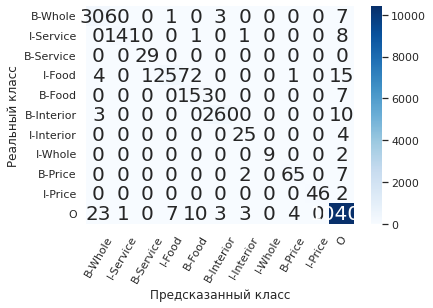

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot  as plt
ytrue = []
for k in y_test:
  ytrue.extend(k)

ypreds = []
for k in y_pred:
  ypreds.extend(k)

plt.figure()
array=confusion_matrix(ytrue, ypreds)
a = labels
df_cm = pd.DataFrame(array, index=a, columns=a)
sn.set(font_scale=1.0)
sn.heatmap(df_cm, annot=True, annot_kws={'size':20}, cmap='Blues', fmt="d")
plt.xticks(rotation=60)
plt.xlabel('Предсказанный класс')
plt.ylabel('Реальный класс')
plt.savefig('image_all.png')
plt.show()

In [102]:
crf_preds = []
for i in y_pred:
   crf_preds.extend(i)

In [121]:
with open('dev_pred_aspects.txt', 'w')as f:
  for k in range(len(crf_preds)):
    if crf_preds[k].startswith('O'):
      pass
    elif crf_preds[k].startswith('B'):
      f.write('\t'.join([text_ids_test[k], texts_test[k], crf_preds[k].replace('B-','')]) + '\n')
    elif crf_preds[k].startswith('I'):
      f.write('\t'.join([text_ids_test[k], texts_test[k], crf_preds[k].replace('I-','')]) + '\n')

## См. также

[python-crfsuite](https://github.com/scrapinghub/python-crfsuite/blob/master/examples/CoNLL%202002.ipynb) - без зависимости от версии scikit-learn

[BERT + CRF for NER](https://github.com/shushanxingzhe/transformers_ner)